## Setup the environment

1. ✅ Remember to change the Colab runtime type to **GPU T4**

### Clone repository

In [ ]:
%env EXERCISE_NAME=04-ape-and-fine-tuning
%env REPO_NAME=llmops-workshop
%env BRANCH_NAME=workshop-prep

In [ ]:
! echo "Cloning the repository...${REPO_NAME}"

In [ ]:
%%bash
git clone https://github.com/getindata/$REPO_NAME.git
cd $REPO_NAME
git checkout $BRANCH_NAME
git stash
git pull

## Tools versions

In [ ]:
%env LLAMA_CPP_VERSION=b5043
%env OLLAMA_VERSION=0.6.3

In [ ]:
def is_colab():
    try:
        import google.colab  # noqa: F401

        return True
    except ImportError:
        return False

### Prepare environment variables, Python modules search path and install dependencies

In [ ]:
import os
if is_colab():
    os.environ["EXERCISE_ROOT"] = f"/content/{os.environ['REPO_NAME']}/exercises"
    os.environ["LD_LIBRARY_PATH"] = "/usr/lib64-nvidia"
    os.environ["EXERCISE_RUN"] = "colab"
else:
    os.environ["EXERCISE_ROOT"] = f"{os.getcwd()}/exercises"
    os.environ["EXERCISE_RUN"] = "local"

os.environ['EXERCISE_DIR'] = f"{os.environ['EXERCISE_ROOT']}/{os.environ['EXERCISE_NAME']}"
get_ipython().run_line_magic("run", f"{os.environ['EXERCISE_ROOT']}/shared/setup/__setup_{os.environ['EXERCISE_RUN']}.ipynb")

In [ ]:
import sys

sys.path.append(f"{os.environ['EXERCISE_DIR']}/src")

In [ ]:
%pip install -r {os.environ['EXERCISE_DIR']}/requirements.txt

## Test the environment

In [ ]:
! LD_LIBRARY_PATH=/usr/lib64-nvidia:/bin/ llama-cli --version

In [ ]:
!ollama --version

In [ ]:
%%bash
ollama pull gemma3:1b > /dev/null 2>&1
curl -sX POST http://localhost:11434/api/generate -d '{
"model": "gemma3:1b",
"system": "Be helpful and concise.",
"prompt":"Who discovered general theory of relativity?.Just answer with the name of the scientist."
}' | jq -r '. | {response} | join(",")' | tr -d '\n'

### Langfuse connection (also OpenTelemetry)

In [ ]:
import base64
import os
import getpass

try:
    from google.colab import userdata  # noqa: F401
except ImportError:
    pass

os.environ["LANGFUSE_SECRET_KEY"] = (
    getpass.getpass("LANGFUSE_SECRET_KEY")
    if not is_colab()
    else userdata.get("LANGFUSE_SECRET_KEY")
)
os.environ["LANGFUSE_PUBLIC_KEY"] = (
    getpass.getpass("LANGFUSE_PUBLIC_KEY")
    if not is_colab()
    else userdata.get("LANGFUSE_PUBLIC_KEY")
)
os.environ["LANGFUSE_HOST"] = (
    getpass.getpass("LANGFUSE_HOST")
    if not is_colab()
    else userdata.get("LANGFUSE_HOST")
)

os.environ["LANGFUSE_AUTH"] = base64.b64encode(
    f"{os.environ['LANGFUSE_PUBLIC_KEY']}:{os.environ['LANGFUSE_SECRET_KEY']}".encode()
).decode()
os.environ["OTEL_EXPORTER_OTLP_TRACES_ENDPOINT"] = (
    f"{os.environ['LANGFUSE_HOST']}/api/public/otel/v1/traces"
)
os.environ["OTEL_EXPORTER_OTLP_TRACES_HEADERS"] = (
    f"Authorization=Basic {os.environ['LANGFUSE_AUTH']}"
)
os.environ["OTEL_EXPORTER_OTLP_TRACES_PROTOCOL"] = "http/protobuf"

### Set your user ID

In [ ]:
os.environ["MY_USER_ID"] = "marek"

In [ ]:
from langfuse import Langfuse

langfuse = Langfuse()
assert langfuse.auth_check()
print(f"Langfuse access works!")

## Data preparation

In [ ]:
import polars as pl

df = pl.read_csv(f"{os.environ['EXERCISE_DIR']}/data/input/sms_phishing.csv")
datasets = []
for r in df.iter_rows(named=True):
    datasets.append({"input": r["TEXT"], "expected_output": r["LABEL"].lower()})

In [ ]:
TRAIN_PCT = 0.9666
VAL_PCT = 0.0167
TEST_PCT = 0.0167
train_ds = datasets[: int(len(datasets) * TRAIN_PCT)]
val_ds = datasets[
    int(len(datasets) * TRAIN_PCT) : int(len(datasets) * (TRAIN_PCT + VAL_PCT))
]
test_ds = datasets[int(len(datasets) * (TRAIN_PCT + VAL_PCT)) :]
len(train_ds), len(val_ds), len(test_ds)

### Create Langfuse datasets (already done by training team)


In [ ]:
def create_dataset(name: str, ds: list):
    langfuse.create_dataset(name=name)
    for item in ds:
        langfuse.create_dataset_item(
            dataset_name=name,
            input=item["input"],
            expected_output=item["expected_output"],
        )

In [ ]:
create_dataset("sms_phishing_train", train_ds)
create_dataset("sms_phishing_val", val_ds)
create_dataset("sms_phishing_test", test_ds)

## Register the prompt (optional)

In [ ]:
langfuse.create_prompt(
    name="sms-classifier",
    type="text",
    prompt=" Given an SMS text, classify whether it is 'ham', 'spam', or 'smishing'. Output only the predicted category.",
    labels=["sandbox"],
    tags=["sms", "dspy", "classifier"],
)

## Create a SMSClassifier module with DSPy

### Configure which LLM to use (Ollama Gemma3)
DSpy uses [LiteLLM](https://www.litellm.ai/) to abstract the LLM provider.

In [ ]:
import dspy

MODEL = "gemma3:1b"

lm = dspy.LM(f"ollama/{MODEL}", cache=False, num_retries=5)
dspy.settings.configure(lm=lm, track_usage=False)

### Configuring DSPy traces with OpenTelemetry using MLflow client
OpenTelemetry is a collection of APIs, SDKs, and tools. Use it to instrument, generate, collect, and export telemetry data (metrics, logs, and traces) to help you analyze your software’s performance and behavior.

In [ ]:
import mlflow

mlflow.dspy.autolog()

In [ ]:
import logging

logger = logging.getLogger("mlflow")
logger.setLevel(logging.INFO)

In [ ]:
lm("Hello world!")

### Create a DSPy module
1. We first create a Signature that defines the schema of the input and output of the module and well as the default instructions.
2. Then we create a Module that combines the Signature with the prompting strategy, such Chain of Thought, ReAct or Predict.
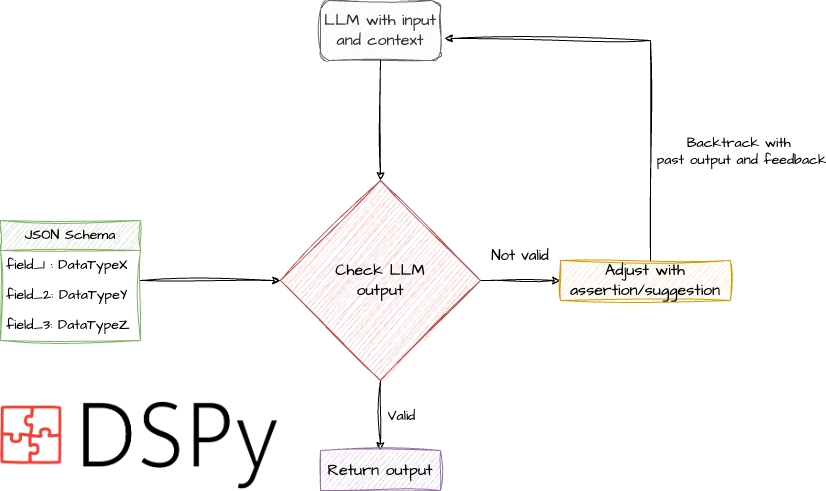


In [ ]:
from typing import Literal

import dspy


class SMSClassifierSignature(dspy.Signature):
    """
    Given an SMS text, predict whether it is ham, spam, or smishing.
    Output only the predicted label.
    """

    sms_text: str = dspy.InputField()
    category: Literal["ham", "spam", "smishing"] = dspy.OutputField()


class SMSClassifier(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.Predict(SMSClassifierSignature)

    @mlflow.trace
    def forward(self, sms_text):
        return self.generate_answer(sms_text=sms_text)

In [ ]:
sms_classifier = SMSClassifier()

### Change the default instructions (optional)
Just to show how we can change the default instructions.

In [ ]:
SMSClassifierSignature.__doc__ = langfuse.get_prompt(
    name="sms-classifier", version=1
).compile()
sms_classifier = SMSClassifier()

In [ ]:
sms_classifier(sms_text="Sorry i missed your call. Can you please call back.")

In [ ]:
sms_classifier(
    sms_text="We have received a request from you for purchasing Paytm Payments Bank FASTag. Total amount to be paid is Rs 250/- (Tag Cost Rs. 100 Security Deposit Rs. 0, Threshold -Rs. 150). In case of any queries, please contact us at https://m.paytm.me/fastag-help"
)

In [ ]:
# wrong should be categorized as spam
sms_classifier(
    sms_text="Rental  Helpline  9999991155 1000-100, 000 sq.ft. In Noida & Gr.Noida  OFFICE & INDUSTRIAL Use Goldenberg estates pvt.ltd. sandeep@goldenberg.in 999 999 115"
)

In [ ]:
lm.inspect_history(n=1)

## Run evaluation on the test dataset

### Pull the models

In [ ]:
%%bash
models=("gemma3:1b" "qwen2.5:14b" "gemma3:12b")
for model in "${models[@]}"; do
    echo "Pulling model: $model"
    ollama pull "$model"
done


### Prepare the test dataset

In [ ]:
dataset = langfuse.get_dataset("sms_phishing_test")
from dspy import Example

test_ds = []
for item in dataset.items:
    test_ds.append(
        Example(sms_text=item.input, category=item.expected_output).with_inputs(
            "sms_text"
        )
    )

In [ ]:
import uuid
from evaluation_helpers import plot_metrics, run_evaluation

baseline_run_id = uuid.uuid1()

models = [
    "gemma3:1b",
    "qwen2.5:14b",
    "gemma3:12b",
]


# full run (if you would like to run all models - remember to pull them first)
# models = [
#         "smollm2:360m", "smollm2:1.7b",
#         "qwen2.5:0.5b", "qwen2.5:1.5b",
#         "gemma3:1b", "gemma3:4b", "granite3.2:2b",
#         "gemma3:12b", "qwen2.5:14b", "phi4:14b"
# ]

classes = ["ham", "spam", "smishing"]

run_evaluation(
    models, sms_classifier, test_ds, classes, baseline_run_id, prefix="baseline"
)

### Short about precision, recall and f1 scores
**precision** tells you, "Of all the items our model predicted as positive, how many were actually positive?"

**recall** tells you, "Of all the actual positive items, how many did our model correctly identify?"

**f1** score is the harmonic mean of precision and recall, giving a single metric that balances both.

In [ ]:
from evaluation_helpers import get_all_metric

metrics_baseline = get_all_metric(models, baseline_run_id, classes, prefix="baseline")

In [ ]:
plot_metrics(
    metrics_baseline,
    ["Precision (macro)", "Recall(macro)", "F1(macro)"],
    "Scores by model before prompt optimization and fine-tuning",
)

## Automatic prompt engineering
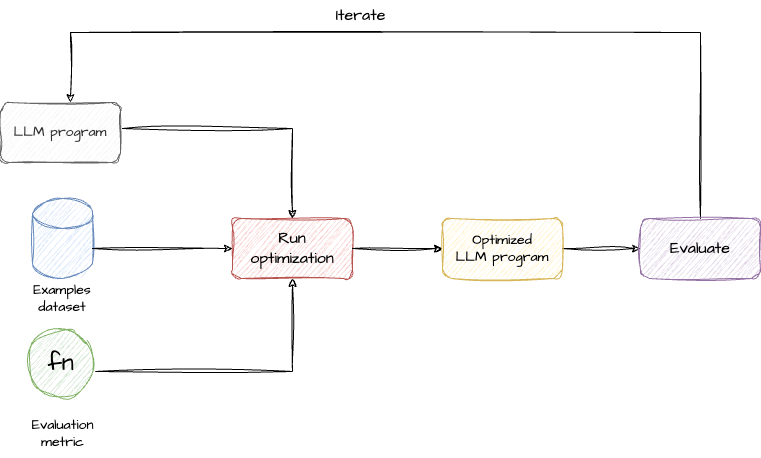

### Prepare the examples dataset

In [ ]:
from collections import Counter
from dspy import Example

dataset = langfuse.get_dataset("sms_phishing_train")

sample_size = 100
category_split = {"ham": 0.6, "spam": 0.2, "smishing": 0.2}
sample_counts = {"ham": 0, "spam": 0, "smishing": 0}
ham_num = sample_size * category_split["ham"]
spam_num = sample_size * category_split["spam"]
smishing_num = sample_size * category_split["smishing"]
train_ds = []
for item in dataset.items:
    train_ds.append(
        Example(sms_text=item.input, category=item.expected_output).with_inputs(
            "sms_text"
        )
    )


categories = [item.category for item in train_ds[:sample_size]]
Counter(categories)

In [ ]:
lm = dspy.LM(f"ollama/{MODEL}", cache=False)
dspy.settings.configure(lm=lm, track_usage=False)

### Evaluation metric (Accuracy)

In [ ]:
def validate_answer(example, pred, trace=None):
    return example.category == pred.category.lower()

### Run optimization
DSPy offers a few optimizers, sucha as

In [ ]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from evaluation_helpers import validate_answer

config = dict(
    max_bootstrapped_demos=2,
    max_labeled_demos=8,
    num_candidate_programs=2,
    num_threads=1,
    max_errors=10,
)

teleprompter = BootstrapFewShotWithRandomSearch(metric=validate_answer, **config)
optimized_program = teleprompter.compile(
    sms_classifier, trainset=train_ds[:sample_size]
)

In [ ]:
optimized_program.save(
    f"{os.environ['EXERCISE_DIR']}/programs/sms_classifier-{MODEL}.json"
)

In [ ]:
optimized_classifier = SMSClassifier()
optimized_classifier.load(
    f"{os.environ['EXERCISE_DIR']}/programs/sms_classifier-{MODEL}.json"
)

In [ ]:
dataset = langfuse.get_dataset("sms_phishing_test")
from dspy import Example

test_ds = []
for item in dataset.items:
    test_ds.append(
        Example(sms_text=item.input, category=item.expected_output).with_inputs(
            "sms_text"
        )
    )

In [ ]:
models = [MODEL]
classes = ["ham", "spam", "smishing"]
ape_run_id = uuid.uuid1()
run_evaluation(models, optimized_classifier, test_ds, classes, ape_run_id, prefix="ape")

In [ ]:
metrics_ape = get_all_metric(models, ape_run_id, classes, prefix="ape")
metrics_ape

In [ ]:
optimized_classifier = SMSClassifier()
optimized_classifier.load(
    f"{os.environ['EXERCISE_DIR']}/programs/sms_classifier-gemma3:1b-100ex-16p.json"
)

In [ ]:
run_evaluation(
    models, optimized_classifier, test_ds, classes, ape_run_id, prefix="ape-100ex-16p"
)

In [ ]:
metrics_ape_16p = get_all_metric(models, ape_run_id, classes, prefix="ape-100ex-16p")
metrics_ape_16p

In [ ]:
metrics_baseline["gemma3:1b-ape"] = metrics_ape["gemma3:1b"]
metrics_baseline["gemma3:1b-ape-100ex-16p"] = metrics_ape_16p["gemma3:1b"]

In [ ]:
plot_metrics(
    metrics_baseline,
    ["Precision (macro)", "Recall(macro)", "F1(macro)"],
    "Scores by model before and after prompt optimization ",
)

### Langfuse evaluation

## Fine-tuning using LoRA method

### Prepare training and validation dataset

In [ ]:
from jinja2 import Template

system_content_str = """
    Your input fields are:
    1. `sms_text` (str)

    Your output fields are:
    1. `category` (Literal['ham', 'spam', 'smishing'])

    All interactions will be structured in the following way, with the appropriate values filled in.

    Inputs will have the following structure:

    [[ ## sms_text ## ]]
    {sms_text}

    Outputs will be a JSON object with the following fields.

    {
      "category": "{category}        # note: the value you produce must be one of: ham; spam; smishing"
    }

    In adhering to this structure, your objective is:
            Given an SMS text, predict whether it is ham, spam, or smishing.
            Output only the predicted label.
        """


user_content_str = """
    [ ## sms_text ## ]]
    {{ sms_text }}

    Respond with a JSON object in the following order of fields: `category` (must be formatted as a valid Python Literal['ham', 'spam', 'smishing']).
"""

predict_str = """
```json
{
  "category": {{ predicted_label | tojson }}
}
```
"""


template_chat_str = """
{
  "messages": [
    {
      "role": "system",
      "content": {{ system_prompt | tojson }}
    },
    {
      "role": "user",
      "content": {{ user_prompt | tojson}}
    },
    {
      "role": "assistant",
      "content": {{ predict | tojson }}
    }
  ]
}
"""

template_complete_str = """
{
  "prompt": "Given an SMS text, predict whether it is ham, spam, or smishing.Output only the predicted label: {{ sms_text }}",
  "completion": "{{ predicted_label }}"
}
"""

In [ ]:
import json

system_template = Template(system_content_str)
user_template = Template(user_content_str)
predict_template = Template(predict_str)
template_chat = Template(template_chat_str)

In [ ]:
dataset = langfuse.get_dataset("sms_phishing_train")
data = []
for item in dataset.items:
    data.append(
        template_chat.render(
            system_prompt=system_template.render(
                sms_text=item.input, category=item.expected_output
            ),
            user_prompt=user_template.render(sms_text=item.input),
            predict=predict_template.render(predicted_label=item.expected_output),
        )
    )

with open(f"{os.environ['EXERCISE_DIR']}/data/train/train.jsonl", "w") as f:
    for record in data:
        try:
            parsed = json.loads(record)
            json_record = json.dumps(parsed)
            f.write(json_record + "\n")
        except json.JSONDecodeError as e:
            pass

In [ ]:
dataset = langfuse.get_dataset("sms_phishing_val")
data = []
for item in dataset.items:
    data.append(
        template_chat.render(
            system_prompt=system_template.render(
                sms_text=item.input, category=item.expected_output
            ),
            user_prompt=user_template.render(sms_text=item.input),
            predict=predict_template.render(predicted_label=item.expected_output),
        )
    )

with open(f"{os.environ['EXERCISE_DIR']}/data/train/valid.jsonl", "w") as f:
    for record in data:
        try:
            parsed = json.loads(record)
            json_record = json.dumps(parsed)
            f.write(json_record + "\n")
        except json.JSONDecodeError as e:
            pass

### Train the model using LoRA

In [ ]:
! mlx_lm.lora --config exercises/04-ape-and-fine-tuning/mlx/config.yaml

### Fuse the model with adapters

In [ ]:
! mlx_lm.fuse --model mlx-community/gemma-3-1b-it-bf16 --adapter-path mlx/adapters-merge --save-path mlx/models/gemma-3-1b-it-bf16-ft

### Convert to GGUF format

In [ ]:
# ! pip install git+https://github.com/ggml-org/llama.cpp.git@2c3f8b850a4a6cff0f5dda2135c03fc81d33ed8b

In [ ]:
%%bash
cd mlx/models
convert_hf_to_gguf.py gemma-3-1b-it-bf16-ft  --outfile gguf/gemma-3-1b-it-bf16-ft.gguf

### Quantize it

In [ ]:
! llama-quantize mlx/models/gguf/gemma-3-1b-it-bf16-ft.gguf mlx/models/gguf/gemma-3-1b-it-q4_K_M.gguf Q4_K_M

In [ ]:
%%bash
du -h mlx/models/gguf/gemma-3-1b-it-bf16-ft.gguf
du -h mlx/models/gguf/gemma-3-1b-it-q4_K_M.gguf

In [ ]:
### Build a model from Modelfile

In [ ]:
%%bash
cd mlx/models
ollama create getindata/gemma3:1b-it-llmops-q4_K_M-w -f Modelfile

In [ ]:
! ollama list | grep getindata/gemma3:1b-it-llmops-q4_K_M-w

### Let's verify it

In [ ]:
! ollama pull getindata/gemma3:1b-it-llmops-q4_K_M

In [ ]:
model = "getindata/gemma3:1b-it-llmops-q4_K_M"

In [ ]:
ft_run_id = uuid.uuid1()
models = [model]
sms_classifier = SMSClassifier()
run_evaluation(models, sms_classifier, test_ds, classes, ft_run_id, prefix="fine-tune")

In [ ]:
metrics_ft = get_all_metric(models, ft_run_id, classes, prefix="fine-tune")
metrics_ft

In [ ]:
metrics_baseline["gemma3:1b-ft"] = metrics_ft[model]

In [ ]:
plot_metrics(
    metrics_baseline,
    ["Precision (macro)", "Recall(macro)", "F1(macro)"],
    "Scores by model before and after prompt optimization and fine-tuning",
)